# Sentinel-1 Level 0 Data Decoding Example

Sentinel-1 is a Synthetic Aperture Mapping satellite constellation operated by the European Space Agency (ESA). ESA publish several types of product associated with each data acquisition. Level 1 and Level 2 data files consist of various types of processed SAR images, but the raw packetized data downlinked to the ground is also available in the form of Level 0 products.

ESA also publish details of the [image formation algorithm used to generate Level 1 products](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library/-/asset_publisher/xlslt4309D5h/content/id/4629294?_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_redirect=https%3A%2F%2Fsentinels.copernicus.eu%2Fweb%2Fsentinel%2Fuser-guides%2Fdocument-library%3Fp_p_id%3Dcom_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_cur%3D2%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_delta%3D10%26p_r_p_resetCur%3Dfalse%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_assetEntryId%3D4629294) and [structure of Sentinel-1 data packets](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library/-/asset_publisher/xlslt4309D5h/content/id/3120468?_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_redirect=https%3A%2F%2Fsentinels.copernicus.eu%2Fweb%2Fsentinel%2Fuser-guides%2Fdocument-library%3Fp_p_id%3Dcom_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_cur%3D13%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_delta%3D10%26p_r_p_resetCur%3Dfalse%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_assetEntryId%3D3120468) in their [document library](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library).

This notebook demonstrates data extraction from Level 0 products using the Sentinel1Decoder Python code at https://github.com/Rich-Hall/sentinel1decoder. An example implementation of the range-Doppler algorithm is also provided to demonstrate image formation from this data.

## 1 - Imports and setup

In [1]:
import sentinel1decoder
import pandas as pd
import numpy as np
import logging
import math
import cmath
import struct
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d

In [2]:
filepath = "../data/sao_paulo/"
filename = "s1a-s3-raw-s-hh-20230518t213602-20230518t213627-048593-05d835.dat"
#filepath = "../data/russia/"
#filename = "s1a-iw-raw-s-vh-20230307t152137-20230307t152158-047540-05b562.dat"
inputfile = filepath+filename

l0file = sentinel1decoder.Level0File(inputfile)

## 2 - Extract File Metadata

Sentinel-1 level 0 data files consist of the raw packetized data sent to the ground. One packet typically consists of the radar instrument output associated with one radar echo, so a single file typically consists of many thousands of packets. Packets may also consist of other types of data e.g. background noise measurements for instrument calibration.

We are working with data acquired in stripmap mode over Sao Paulo and the nearby port of Santos, Brazil. Stripmap data is mainly used to monitor small islands, so is relatively infrequently used. However, it is relatively simple compared to Interferometric Wide Swath mode, the main acquisiton mode used over land, and therefore makes our task of image formation much simpler!

Initially we're going to pull the metadata from each packet and output to a Pandas dataframe to examine the file contents. Producing an image from the entirity of the data found in a single file would take a long time and require a lot of memory, so we're aiming to produce an image from just a subset of this data.

In [3]:
l0file.packet_metadata

Packet Version Number  Packet Type   
Azimuth Block Number Packet Number                                       
1                    0                                  0            0  \
                     1                                  0            0   
                     2                                  0            0   
                     3                                  0            0   
                     4                                  0            0   
...                                                   ...          ...   
16                   48936                              0            0   
                     48937                              0            0   
                     48938                              0            0   
                     48939                              0            0   
                     48940                              0            0   

                                    Secondary Header Flag  PID  PCAT   
Azimuth Block Number Packet Number                                     
1                    0                                  1   65    12  \
                     1                                  1   65    12   
                     2                                  1   65    12   
                     3                                  1   65    12   
                     4                                  1   65    12   
...                                                   ...  ...   ...   
16                   48936                              1   65    12   
                     48937                              1   65    12   
                     48938                              1   65    12   
                     48939                              1   65    12   
                     48940                              1   65    12   

                                    Sequence Flags  Packet Sequence Count   
Azimuth Block Number Packet Number                                          
1                    0                           3                      0  \
                     1                           3                      1   
                     2                           3                      2   
                     3                           3                      3   
                     4                           3                      4   
...                                            ...                    ...   
16                   48936                       3                     40   
                     48937                       3                     41   
                     48938                       3                     42   
                     48939                       3                     43   
                     48940                       3                     44   

                                    Packet Data Length  Coarse Time   
Azimuth Block Number Packet Number                                    
1                    0                           27454   1368480980  \
                     1                           27454   1368480980   
                     2                           27454   1368480980   
                     3                           27454   1368480980   
                     4                           27454   1368480980   
...                                                ...          ...   
16                   48936                       27518   1368481005   
                     48937                       27518   1368481005   
                     48938                       27518   1368481005   
                     48939                       27518   1368481005   
                     48940                       27518   1368481005   

                                    Fine Time  ...       SWL  SAS SSB Flag   
Azimuth Block Number Packet Number             ...                           
1                    0               0.327492  ...  0.

The satellite ephemeris data is sub-commutated across multiple packets due to its relatively low update rate, so we need to perform an extra step to extract this information.

In [4]:
l0file.ephemeris

,X-axis position ECEF,Y-axis position ECEF,Z-axis position ECEF,X-axis velocity ECEF,Y-axis velocity ECEF,Z-axis velocity ECEF,POD Solution Data Timestamp,Q0 Attitude Quaternion,Q1 Attitude Quaternion,Q2 Attitude Quaternion,Q3 Attitude Quaternion,Omega-X Angular Rate,Omega-Y Angular Rate,Omega-Z Angular Rate,Attitude Data Timestamp
0,4.140341e+06,-4.902705e+06,-2.991455e+06,759.300415,-3449.252686,6717.096191,1.368481e+09,-0.431256,-0.436010,0.279961,-0.738604,0.000044,-0.000902,-0.000553,1.368481e+09
1,4.140341e+06,-4.902705e+06,-2.991455e+06,759.300415,-3449.252686,6717.096191,1.368481e+09,-0.431256,-0.436010,0.279961,-0.738604,0.000044,-0.000902,-0.000553,1.368481e+09
2,4.140341e+06,-4.902705e+06,-2.991455e+06,759.300415,-3449.252686,6717.096191,1.368481e+09,-0.431256,-0.436010,0.279961,-0.738604,0.000044,-0.000902,-0.000553,1.368481e+09
3,4.140341e+06,-4.902705e+06,-2.991455e+06,759.300415,-3449.252686,6717.096191,1.368481e+09,-0.431256,-0.436010,0.279961,-0.738604,0.000044,-0.000902,-0.000553,1.368481e+09
4,4.140341e+06,-4.902705e+06,-2.991455e+06,759.300415,-3449.252686,6717.096191,1.368481e+09,-0.431256,-0.436010,0.279961,-0.738604,0.000044,-0.000902,-0.000553,1.368481e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,4.157720e+06,-4.987246e+06,-2.822494e+06,630.990906,-3313.561523,6798.956055,1.368481e+09,-0.432909,-0.446483,0.281386,-0.730798,0.000043,-0.000905,-0.000554,1.368481e+09
758,4.157720e+06,-4.987246e+06,-2.822494e+06,630.990906,-3313.561523,6798.956055,1.368481e+09,-0.432909,-0.446483,0.281386,-0.730798,0.000043,-0.000905,-0.000554,1.368481e+09
759,4.157720e+06,-4.987246e+06,-2.822494e+06,630.990906,-3313.561523,6798.956055,1.368481e+09,-0.432909,-0.446483,0.281386,-0.730798,0.000043,-0.000905,-0.000554,1.368481e+09
760,4.157720e+06,-4.987246e+06,-2.822494e+06,630.990906,-3313.561523,6798.956055,1.368481e+09,-0.432909,-0.446483,0.281386,-0.730798,0.000043,-0.000905,-0.000554,1.368481e+09


## 3 - Extract Data

### 3.1 - Select Packets to Process

Now we've extracted all the packet metadata, we're going to select the data packets we'll be processing. We want to exclude all packets that don't contain SAR instrument returns, and then pick a small set of these to operate on. For this example we'll be focusing on the coastline around the port of Santos.

In [5]:
selected_burst = 8
selection = l0file.get_burst_metadata(selected_burst)
selection

,Packet Version Number,Packet Type,Secondary Header Flag,PID,PCAT,Sequence Flags,Packet Sequence Count,Packet Data Length,Coarse Time,Fine Time,...,SWL,SAS SSB Flag,Polarisation,Temperature Compensation,Calibration Mode,Tx Pulse Number,Signal Type,Swap Flag,Swath Number,Number of Quads
Packet Number,,,,,,,,,,,,,,,,,,,,,
408,0,0,1,65,12,3,24,15734,1368480980,0.601784,...,0.000329,0,3,3,0,2,0,0,2,10919
409,0,0,1,65,12,3,25,15890,1368480980,0.602303,...,0.000329,0,3,3,0,2,0,0,2,10919
410,0,0,1,65,12,3,26,15954,1368480980,0.602821,...,0.000329,0,3,3,0,2,0,0,2,10919
411,0,0,1,65,12,3,27,15966,1368480980,0.603340,...,0.000329,0,3,3,0,2,0,0,2,10919
412,0,0,1,65,12,3,28,15914,1368480980,0.603859,...,0.000329,0,3,3,0,2,0,0,2,10919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19653,0,0,1,65,12,3,5,14298,1368480990,0.599403,...,0.000329,0,3,3,0,2,0,0,2,10919
19654,0,0,1,65,12,3,6,14326,1368480990,0.599922,...,0.000329,0,3,3,0,2,0,0,2,10919
19655,0,0,1,65,12,3,7,14330,1368480990,0.600441,...,0.000329,0,3,3,0,2,0,0,2,10919


### 3.2 - Extract Raw I/Q Sensor Data

Now we're ready to extract the raw sensor output from the file. The result will be a set of complex I/Q samples measured by the SAR instrument. By stacking these horizontally we can produce a 2D array of data samples, with fast time $\tau$ along one axis and slow time $\eta$ along the other. Since all the required information to do this is contained in packet metadata, the decoder outputs data arranged like this automatically.

In [6]:
# Decode the IQ data
radar_data = l0file.get_burst_data(selected_burst)

# Cache this data so we can retreive it more quickly next time we want it
l0file.save_burst_data(selected_burst)

Plotting our array, we can see that although there is clearly some structure to the data, we can't yet make out individual features. Our image needs to be focused along both the range and azimuth axes.

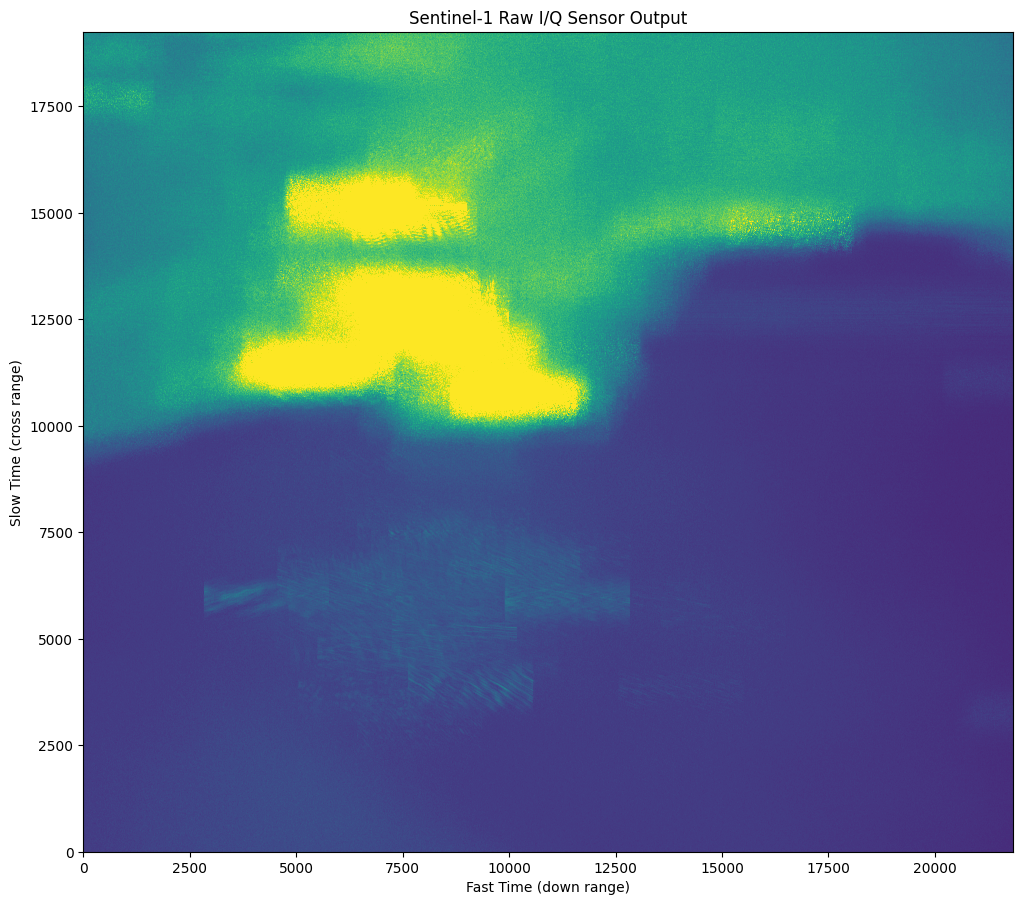

In [7]:
# Plot the raw IQ data extracted from the data file
plt.figure(figsize=(12, 12))
plt.title("Sentinel-1 Raw I/Q Sensor Output")
plt.imshow(abs(radar_data[:,:]), vmin=0, vmax=15, origin='lower')
plt.xlabel("Fast Time (down range)")
plt.ylabel("Slow Time (cross range)")
plt.show()

## 4 - Image Processing

The following section demonstrates an implementation of the range-Doppler algorithm. This essentially consists of the following steps:
- Range compression
- Transform to range-Doppler domain
- Range Cell Migration Correction (RCMC)
- Azimuth compression
- Transform to time domain
- Image formation

### 4.1 - Define auxiliary parameters

We require a number of parameters in the calculations that follow, so we'll define them all here. These are:
- Image sizes
- Various transmitted pulse parameters used to synthesize a replica Tx pulse
- Sample rates in range and azimuth
- The fast time $\tau$ associated with each range sample along a range line, and the corresponding slant range of closest approach $R_{0}$ for each of these range samples
- The frequency axes in range $f_{\tau}$ and azimuth $f_{\eta}$ after transforming our array to the frequency domain
- The effective spacecraft velocity $V_{r}$. This is a psuedo velocity approximated by $V_{r} \approx \sqrt{V_{s} V_{g}}$, where $V_{s}$ is the norm of the satellite velocity vector, and $V_{g}$ is the antenna beam velocity projected onto the ground. $V_{g}$ is calculated numerically acording to the method defined in https://iopscience.iop.org/article/10.1088/1757-899X/1172/1/012012/pdf. Note that $V_{g}$ and hence $V_{r}$ varies by slant range.
- The cosine of the instantaneous squint angle $D(f_{\eta}, V_{r})$, where

$$D(f_{\eta}, V_{r}) = \sqrt{1 - \frac{c^{2} f_{\eta}^{2}}{4 V_{r}^{2} f_{0}^{2}}}$$


In [8]:
# Image sizes
len_range_line = radar_data.shape[1]
len_az_line = radar_data.shape[0]

# Tx pulse parameters
c = sentinel1decoder.constants.SPEED_OF_LIGHT_MPS
RGDEC = selection["Range Decimation"].unique()[0]
PRI = selection["PRI"].unique()[0]
rank = selection["Rank"].unique()[0]
suppressed_data_time = 320/(8*sentinel1decoder.constants.F_REF)
range_start_time = selection["SWST"].unique()[0] + suppressed_data_time
wavelength = sentinel1decoder.constants.TX_WAVELENGTH_M

# Sample rates
range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
range_sample_period = 1/range_sample_freq
az_sample_freq = 1 / PRI
az_sample_period = PRI

# Fast time vector - defines the time axis along the fast time direction
sample_num_along_range_line = np.arange(0, len_range_line, 1)
fast_time_vec = range_start_time + (range_sample_period * sample_num_along_range_line)

# Slant range vector - defines R0, the range of closest approach, for each range cell
slant_range_vec = ((rank * PRI) + fast_time_vec) * c/2
    
# Axes - defines the frequency axes in each direction after FFT
SWL = len_range_line/range_sample_freq
az_freq_vals = np.arange(-az_sample_freq/2, az_sample_freq/2, 1/(PRI*len_az_line))
range_freq_vals = np.arange(-range_sample_freq/2, range_sample_freq/2, 1/SWL)
 
# Spacecraft velocity - numerical calculation of the effective spacecraft velocity
ecef_vels = l0file.ephemeris.apply(lambda x: math.sqrt(x["X-axis velocity ECEF"]**2 + x["Y-axis velocity ECEF"]**2 +x["Z-axis velocity ECEF"]**2), axis=1)
velocity_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(), fill_value="extrapolate")
x_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["X-axis position ECEF"].unique(), fill_value="extrapolate")
y_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Y-axis position ECEF"].unique(), fill_value="extrapolate")
z_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Z-axis position ECEF"].unique(), fill_value="extrapolate")
space_velocities = selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

x_positions = selection.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
y_positions = selection.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
z_positions = selection.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

position_array = np.transpose(np.vstack((x_positions, y_positions, z_positions)))

a = sentinel1decoder.constants.WGS84_SEMI_MAJOR_AXIS_M
b = sentinel1decoder.constants.WGS84_SEMI_MINOR_AXIS_M
H = np.linalg.norm(position_array, axis=1)
W = np.divide(space_velocities, H)
lat = np.arctan(np.divide(position_array[:, 2], position_array[:, 0]))
local_earth_rad = np.sqrt(
    np.divide(
        (np.square(a**2 * np.cos(lat)) + np.square(b**2 * np.sin(lat))),
        (np.square(a * np.cos(lat)) + np.square(b * np.sin(lat)))
    )
)
cos_beta = (np.divide(np.square(local_earth_rad) + np.square(H) - np.square(slant_range_vec[:, np.newaxis]) , 2 * local_earth_rad * H))
ground_velocities = local_earth_rad * W * cos_beta

effective_velocities = np.sqrt(space_velocities * ground_velocities)

D = np.sqrt(
    1 - np.divide(
        wavelength**2 * np.square(az_freq_vals),
        4 * np.square(effective_velocities)
    )
).T

# We're only interested in keeping D, so free up some memory by deleting these large arrays.
del effective_velocities
del ground_velocities
del cos_beta
del local_earth_rad
del H
del W
del lat

### 4.2 - Convert data to 2D frequency domain

We're going to be doing almost all our calculations in the frequency domain, so the first step is to FFT along the azimuth and range axes.

In [9]:
# FFT each range line
radar_data = np.fft.fft(radar_data, axis=1)

# FFT each azimuth line
radar_data = np.fft.fftshift(np.fft.fft(radar_data, axis=0), axes=0)

### 4.3 - Range compression - create and apply matched filter

Range compression is relatively simple. Range information is encoded in the arrival time of the pulse echo (i.e. an echo from a target further away will take longer to arrive), so by applying a matched filter consisting of the transmitted pulse, we can effectively focus the image along the range axis.

We can synthesize a replica of the Tx pulse from parameters specified in the packet metadata. Since we're operating in the frequency domain, we also need to transform our pulse replica that we're using as a matched filter to the frequency domain, then take the complex conjugate. FInally, we need to multiply every range line by our matched filter.

The Tx pulse replica is given by

$$\text{Tx Pulse} = exp\biggl\{2i\pi\Bigl(\bigl(\text{TXPSF} + \frac{\text{TXPRR  TXPL}}{2}\bigl)\tau + \frac{\text{TXPRR}}{2}\tau^{2}\Bigl)\biggl\}$$

where $\text{TXPSF}$ is the Tx Pulse Start Frequency, $\text{TXPRR}$ is the Tx Pulse Ramp Rate, and $\text{TXPL}$ is the Tx Pulse Length.

In [10]:
# Create replica pulse
TXPSF = selection["Tx Pulse Start Frequency"].unique()[0]
TXPRR = selection["Tx Ramp Rate"].unique()[0]
TXPL = selection["Tx Pulse Length"].unique()[0]
num_tx_vals = int(TXPL*range_sample_freq)
tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
phi1 = TXPSF + TXPRR*TXPL/2
phi2 = TXPRR/2
tx_replica = np.exp(2j * np.pi * (phi1*tx_replica_time_vals + phi2*tx_replica_time_vals**2))

# Create range filter from replica pulse
range_filter = np.zeros(len_range_line, dtype=complex)
index_start = np.ceil((len_range_line-num_tx_vals)/2)-1
index_end = num_tx_vals+np.ceil((len_range_line-num_tx_vals)/2)-2
range_filter[int(index_start):int(index_end+1)] = tx_replica
range_filter = np.conjugate(np.fft.fft(range_filter))

# Apply filter
radar_data = np.multiply(radar_data, range_filter)

del range_filter
del tx_replica

### 4.4 - Range cell migration correction

Since the collector motion couples range and azimuth information, point targets will tend to produce returns spread in arcs across multiple range bins as the azimuth varies. We therefore need to apply a shift to align the phase history associated with each pointlike target into a single range bin, so we can then operate 1-dimensionally along the azimuth axis to perform azimuth compresison.

The RCMC shift is defined by

$$\text{RCMC shift} = R_{0} \biggl(\frac{1}{D} - 1\biggl)$$

with $D$ being the cosine of the instantaneous squint angle and $R_{0}$ the range of closest approach, both defined in section 4.1. Since we're still operating in the frequency domain we need to apply a filter of the form

$$\text{RCMC filter} = exp\biggl\{4i\pi\frac{f_{\tau}}{c}\bigl(\text{RCMC shift}\bigl)\biggl\}$$

Again, this needs to be multiplied by every range line in our data.

In [11]:
# Create RCMC filter
range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)
rcmc_shift = slant_range_vec[0] * (np.divide(1, D) - 1)
rcmc_filter = np.exp(4j * np.pi * range_freq_vals * rcmc_shift / c)

# Apply filter
radar_data = np.multiply(radar_data, rcmc_filter)

del rcmc_shift
del rcmc_filter
del range_freq_vals

### 4.5 - Convert to range-Doppler domain

We've finished processing the image in range, so we can inverse FFT back to the range domain along the range axis. The image will still be in the frequency domain in azimuth.

In [12]:
radar_data = np.fft.ifftshift(np.fft.ifft(radar_data, axis=1), axes=1)

### 4.6 - Azimuth compression - create and apply matched filter

Our azimuth filter is defined by

$$\text{Azimuth filter} = exp\biggl\{4i\pi\frac{R_{0}D(f_{\eta}, V_{r})}{\lambda}\biggl\}$$

In [13]:
# Create filter
az_filter = np.exp(4j * np.pi * slant_range_vec * D / wavelength)

# Apply filter
radar_data = np.multiply(radar_data, az_filter)

del az_filter

### 4.7 - Transform back to range-azimuth domain

Finally, we'll transform back out of the frequency domain by taking the inverse FFT of each azimuth line.

In [14]:
radar_data = np.fft.ifft(radar_data, axis=0)

## 5 - Plot Results

With azimuth compression complete, we're ready to plot our image!

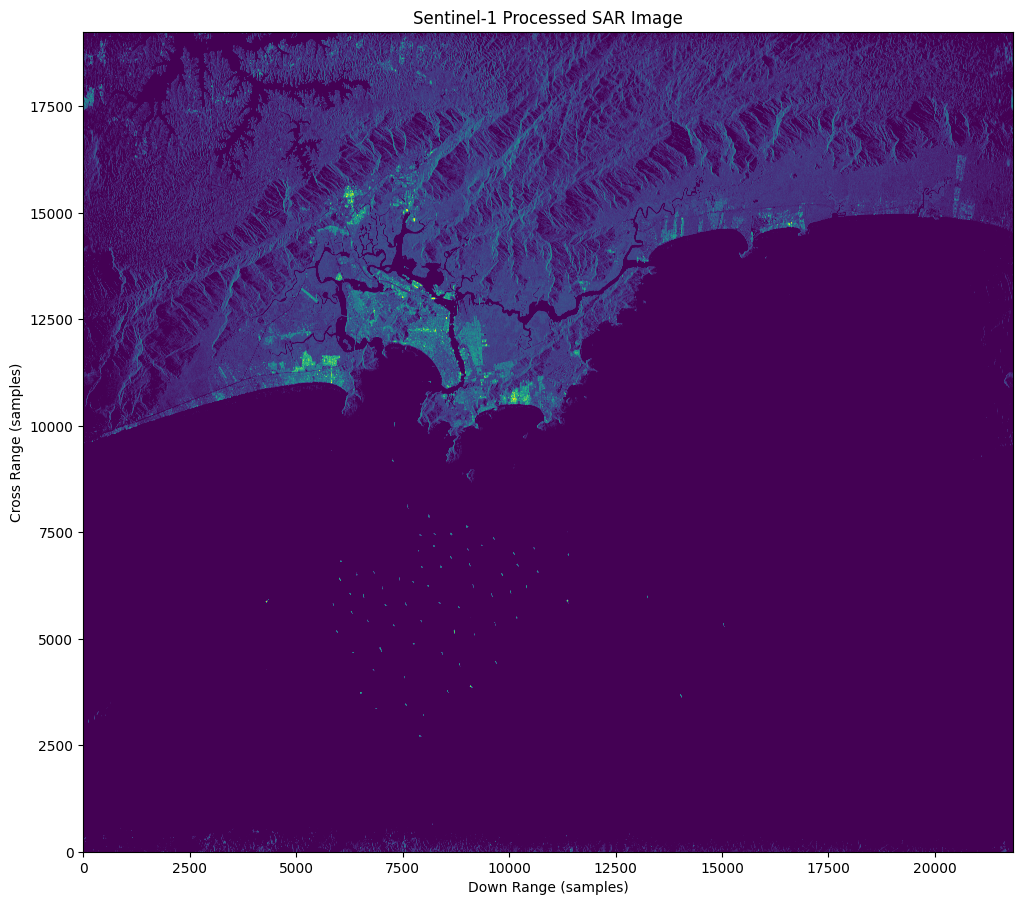

In [15]:
# Plot final image
plt.figure(figsize=(12, 12))
plt.title("Sentinel-1 Processed SAR Image")
#plt.imshow(abs(radar_data[:,:]), vmin=0, vmax=2000, origin='lower')
plt.imshow(abs(radar_data), origin='lower', norm=colors.LogNorm(vmin=300, vmax=10000))
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()

There are still a few noteworthy issues with our image. The first is folding - notice various terrain features from the top of the image are folded into the bottom, and terrain from the left of the image is folded into the right side. Folding in range (range ambiguities) occurs due to echoes spilling over into earlier or later sampling windows. Folding in azimuth occurs due to our sampling the azimuth spectrum of the scene at the PRF, which leads to folding in the frequency spectrum.

Various terrain features are clearly visible, however the image is still not perfectly focused. We have assumed a Doppler centroid of 0Hz, and have not applied a number of additional processing steps that ESA use to produce Level 1 products e.g. Secondary Range Compression (SRC). These are left as an exercise for the reader.